#Feature Engineering : Used Car Prices

##In this exercise, we'll aim to evaluate our current features, and possibly create better features that will have a better impact on our model. We'll be using MI scores to evaluate our features.

##Disclaimer : This exercise is purely a demonstration of my feature engineering knowledge and associated mechanisms I have learnt in the process. This isn't a best practices guide to be followed when working with real models where issues of overfitting may arise from certain feature engieering methods we'll be using. Care must be taken, whenever feature engineering techniques are used to prevent overfitting, target leakage, and other such issues

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

#By : Karthik Sabareesh


Github: https://github.com/KarthikSabareesh

###Importing Data

In [ ]:
dftest=pd.read_csv("/content/UCPPTest - CarPriceTest.csv")
dftrain=pd.read_csv("/content/UCPPTrain - CarPriceTrain.csv")
print(dftest.head(20))

         brand                           model    year  mileage  \
0         FIAT                124 Spider Lusso  2020.0  30830.0   
1        Lexus                 RX 450h F Sport  2019.0  58274.0   
2          Kia                     Stinger GT1  2018.0  69303.0   
3         MINI            Convertible Cooper S  2023.0   5026.0   
4       Nissan                        Murano S  2018.0  61180.0   
5       Toyota            Highlander Hybrid LE  2022.0  52250.0   
6     Cadillac         Escalade Sport Platinum  2021.0  29245.0   
7     Cadillac          CT5 Premium Luxury AWD  2020.0  16883.0   
8         Land   Rover Range Rover Evoque Pure  2013.0  86610.0   
9        Lexus                  IS 350 F Sport  2023.0   2272.0   
10    Maserati                        Ghibli S  2018.0  19267.0   
11        Alfa          Romeo Stelvio Ti Sport  2020.0  24667.0   
12  Mitsubishi            Lancer Evolution GSR  2013.0  47392.0   
13        Jeep           Grand Cherokee Summit  2020.0  22025.

In [ ]:
dftrain.info()
dftrain = dftrain.dropna(subset=['price'])

# Resetting the indices using df.reset_index()
dftrain = dftrain.reset_index(drop=True)

dftest = dftest.dropna(subset=['price'])

# Resetting the indices using df.reset_index()
dftest = dftest.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19109 entries, 0 to 19108
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   brand                        19075 non-null  object 
 1   model                        19075 non-null  object 
 2   year                         19075 non-null  float64
 3   mileage                      19075 non-null  float64
 4   engine                       19030 non-null  object 
 5   engine_size                  17828 non-null  float64
 6   transmission                 18977 non-null  object 
 7   automatic_transmission       19075 non-null  float64
 8   fuel_type                    19075 non-null  object 
 9   drivetrain                   19075 non-null  object 
 10  min_mpg                      16074 non-null  float64
 11  max_mpg                      16074 non-null  float64
 12  damaged                      18909 non-null  float64
 13  first_owner     

In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19075 entries, 0 to 19074
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   brand                        19075 non-null  object 
 1   model                        19075 non-null  object 
 2   year                         19075 non-null  float64
 3   mileage                      19075 non-null  float64
 4   engine                       19030 non-null  object 
 5   engine_size                  17828 non-null  float64
 6   transmission                 18977 non-null  object 
 7   automatic_transmission       19075 non-null  float64
 8   fuel_type                    19075 non-null  object 
 9   drivetrain                   19075 non-null  object 
 10  min_mpg                      16072 non-null  float64
 11  max_mpg                      16072 non-null  float64
 12  damaged                      18909 non-null  float64
 13  first_owner     

##Train-Test Split

In [ ]:
y_train=dftrain["price"]
X_train_full=dftrain.drop("price",axis=1)
y_test=dftest["price"]
X_test_full=dftest.drop("price",axis=1)
print(X_train_full)

            brand                      model    year   mileage  \
0           Mazda               CX-9 Touring  2022.0    6580.0   
1            Alfa  Romeo Stelvio 4DR SUV AWD  2018.0   62717.0   
2       Chevrolet  Silverado 1500 Limited LT  2022.0   15463.0   
3            Land  Rover Range Rover P400 SE  2022.0    1281.0   
4      Mitsubishi     Outlander Sport 2.0 SE  2021.0   36727.0   
...           ...                        ...     ...       ...   
19070       Lexus                RC 350 Base  2017.0   77886.0   
19071   Chevrolet                 Camaro 2SS  2020.0   30921.0   
19072     Hyundai       Palisade Calligraphy  2021.0   25490.0   
19073       Honda               Accord Sport  2019.0   30840.0   
19074        MINI   Countryman Cooper S ALL4  2016.0  110107.0   

                                          engine  engine_size  \
0                     2.5L I4 16V GDI DOHC Turbo          2.5   
1      Twin Turbo Premium Unleaded V-6 2.9 L/176          2.9   
2           

##Preprocessing(Encoding the categorical features, imputing missing values, scaling(if necessary),removing outliers etc.)
#####Here, before we can further perform operations to analyse the dataset and come to conclusions on features to use, we need to preprocess our dataset and get it to a state where we can apply correlation, MI and other such functions to analyse exactly to what degree each attribute affects our price prediction.

In [ ]:
X_train_full["engine"].describe()

count                          19030
unique                          1161
top       2.0L I4 16V GDI DOHC Turbo
freq                            2324
Name: engine, dtype: object

In [ ]:
categorical_cols=[cols for cols in X_train_full.columns if X_train_full[cols].dtype=="object"]
numerical_cols=[cols for cols in X_train_full.columns if X_train_full[cols].dtype in ["int64","float64"] ]
print(categorical_cols)
print(numerical_cols)

['brand', 'model', 'engine', 'transmission', 'fuel_type', 'drivetrain', 'interior_color', 'exterior_color']
['year', 'mileage', 'engine_size', 'automatic_transmission', 'min_mpg', 'max_mpg', 'damaged', 'first_owner', 'personal_using', 'turbo', 'alloy_wheels', 'adaptive_cruise_control', 'navigation_system', 'power_liftgate', 'backup_camera', 'keyless_start', 'remote_start', 'sunroof/moonroof', 'automatic_emergency_braking', 'stability_control', 'leather_seats', 'memory_seat', 'third_row_seating', 'apple_car_play/android_auto', 'bluetooth', 'usb_port', 'heated_seats']


##Feature Engineering
###We aim to create, alter, or obtain information about the current features to create and engineer better features that can reliably show a stronger effect on target variable

###1) Target Encoding
#####In a dataset with such massive cardinality like the one we are currently dealing with, target encoding is an option to try out.

In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X_encode = X_train_full.sample(frac=0.25)
y_encode = y_train[X_encode.index]
X_pretrain = X_train_full.drop(X_encode.index)
y_train = y_train[X_pretrain.index]

In [ ]:
print(X_encode)

            brand                               model    year  mileage  \
967         Volvo                      S60 T5 Dynamic  2018.0  70318.0   
414     Chevrolet       Silverado 1500 Limited Custom  2022.0  30052.0   
3678   Mitsubishi                        Outlander SE  2022.0   8532.0   
10704      Nissan                        Altima 2.5 S  2017.0  72924.0   
12294         BMW                           530e 530e  2021.0  24150.0   
...           ...                                 ...     ...      ...   
16807      Nissan                              Leaf S  2019.0  15155.0   
10817  Volkswagen                        Jetta 1.4T S  2019.0  72477.0   
14041      Nissan                 Pathfinder Platinum  2022.0  18311.0   
18746      Jaguar                             XF Base  2012.0  84522.0   
8619        Mazda  CX-50 2.5 S Preferred Plus Package  2023.0   7539.0   

                                  engine  engine_size           transmission  \
967           2.0L I4 16V GDI D

In [ ]:
X_encodet = X_test_full.sample(frac=0.25)
y_encodet = y_test[X_encodet.index]
X_pretest = X_test_full.drop(X_encodet.index)
y_test = y_test[X_pretest.index]
print(X_encodet)

              brand                       model    year   mileage  \
4713         Toyota             4Runner Limited  2019.0   45520.0   
4075        Hyundai                  Elantra SE  2019.0   80630.0   
4358           MINI      Countryman Cooper ALL4  2020.0   70376.0   
2574  Mercedes-Benz               AMG G 63 Base  2021.0   19794.0   
1166     Mitsubishi               Outlander SEL  2020.0   50932.0   
...             ...                         ...     ...       ...   
752            Land  Rover Range Rover P525 HSE  2020.0   41895.0   
789            Ford            Explorer Limited  2018.0   36344.0   
2524           Jeep    Wrangler Unlimited Sport  2016.0  108000.0   
161            Ford              Transit-350 XL  2021.0   67420.0   
2141      Chevrolet           Silverado 1500 WT  2017.0   84660.0   

                                                 engine  engine_size  \
4713                              4.0L V6 24V MPFI DOHC          4.0   
4075  Nu 2L I-4 DOHC, D-CVV

In [ ]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["brand"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_1 = encoder.transform(X_pretrain)

print(X_train_1.head(50))

# Create the encodetr instance. Choose m to control noise.
encodetr = MEstimateEncoder(cols=["brand"], m=5.0)

# Fit the encodetr on the encoding split.
encodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_1 = encodetr.transform(X_pretest)
print(X_test_1.head(50))

           brand                              model    year   mileage  \
0   25599.904248                       CX-9 Touring  2022.0    6580.0   
2   36166.193051          Silverado 1500 Limited LT  2022.0   15463.0   
3   51023.950905          Rover Range Rover P400 SE  2022.0    1281.0   
5   16012.380930                          500 Sport  2012.0   83908.0   
6   28946.160838                       Carnival LXS  2022.0   43705.0   
8   26406.934208              Pilot Special Edition  2021.0   51299.0   
9   37347.702174            Grand Cherokee Altitude  2019.0   36120.0   
11  20676.661858                 Outlander Sport SE  2021.0   31976.0   
12  93734.893992                                968  1994.0   92025.0   
13  20792.109376                     Hardtop Cooper  2016.0   43418.0   
16  27668.764579                          Sentra SV  2017.0   61872.0   
17  37347.702174            Grand Cherokee Altitude  2018.0   88138.0   
18  25599.904248                       CX-3 Touring

In [ ]:
print(X_train_1.head(50))

           brand                              model    year   mileage  \
0   25599.904248                       CX-9 Touring  2022.0    6580.0   
2   36166.193051          Silverado 1500 Limited LT  2022.0   15463.0   
3   51023.950905          Rover Range Rover P400 SE  2022.0    1281.0   
5   16012.380930                          500 Sport  2012.0   83908.0   
6   28946.160838                       Carnival LXS  2022.0   43705.0   
8   26406.934208              Pilot Special Edition  2021.0   51299.0   
9   37347.702174            Grand Cherokee Altitude  2019.0   36120.0   
11  20676.661858                 Outlander Sport SE  2021.0   31976.0   
12  93734.893992                                968  1994.0   92025.0   
13  20792.109376                     Hardtop Cooper  2016.0   43418.0   
16  27668.764579                          Sentra SV  2017.0   61872.0   
17  37347.702174            Grand Cherokee Altitude  2018.0   88138.0   
18  25599.904248                       CX-3 Touring

Here, we see that the brand column has been encoded according to it's relationship with target. We repeat this process for other categorical features and try to find the target encoded values

In [ ]:
# Create the encoder instance. Choose m to control noise.
modelencoder = MEstimateEncoder(cols=["model"], m=5.0)

# Fit the encoder on the encoding split.
modelencoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_2 = modelencoder.transform(X_train_1)
print(X_train_2.head(50))

# Create the encodetr instance. Choose m to control noise.
modelencodetr = MEstimateEncoder(cols=["model"], m=5.0)

# Fit the encodetr on the encoding split.
modelencodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_2 = modelencodetr.transform(X_test_1)
print(X_test_2.head(50))

           brand         model    year   mileage  \
0   25599.904248  30788.962687  2022.0    6580.0   
2   36166.193051  37573.265674  2022.0   15463.0   
3   51023.950905  56308.721395  2022.0    1281.0   
5   16012.380930  14572.173135  2012.0   83908.0   
6   28946.160838  38130.166046  2022.0   43705.0   
8   26406.934208  38193.761196  2021.0   51299.0   
9   37347.702174  36673.916046  2019.0   36120.0   
11  20676.661858  25317.938943  2021.0   31976.0   
12  93734.893992  37573.265674  1994.0   92025.0   
13  20792.109376  22387.729012  2016.0   43418.0   
16  27668.764579  28162.666216  2017.0   61872.0   
17  37347.702174  36673.916046  2018.0   88138.0   
18  25599.904248  29607.791046  2017.0   42142.0   
19  36424.913557  33735.420182  2019.0   20444.0   
22  28946.160838  37873.388062  2022.0    5964.0   
25  37347.702174  32025.173135  2018.0   71726.0   
26  31649.878402  37573.265674  2022.0    9980.0   
27  52275.122871  42573.888062  2018.0   30245.0   
29  16012.38

In [ ]:
# Create the encoder instance. Choose m to control noise.
engineencoder = MEstimateEncoder(cols=["engine"], m=5.0)

# Fit the encoder on the encoding split.
engineencoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_3 = engineencoder.transform(X_train_2)
print(X_train_3.head(50))

# Create the encodetr instance. Choose m to control noise.
engineencodetr = MEstimateEncoder(cols=["engine"], m=5.0)

# Fit the encodetr on the encoding split.
engineencodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_3 = engineencodetr.transform(X_test_2)
print(X_test_3.head(50))

           brand         model    year   mileage        engine  engine_size  \
0   25599.904248  30788.962687  2022.0    6580.0  33775.658209          2.5   
2   36166.193051  37573.265674  2022.0   15463.0  47858.552918          5.3   
3   51023.950905  56308.721395  2022.0    1281.0  55544.587959          3.0   
5   16012.380930  14572.173135  2012.0   83908.0  13037.310650          1.4   
6   28946.160838  38130.166046  2022.0   43705.0  38898.613983          3.5   
8   26406.934208  38193.761196  2021.0   51299.0  35823.100450          3.5   
9   37347.702174  36673.916046  2019.0   36120.0  36010.160583          3.6   
11  20676.661858  25317.938943  2021.0   31976.0  18585.018190          2.0   
12  93734.893992  37573.265674  1994.0   92025.0  37573.265674          3.0   
13  20792.109376  22387.729012  2016.0   43418.0  23991.129150          1.5   
16  27668.764579  28162.666216  2017.0   61872.0  18856.013682          1.8   
17  37347.702174  36673.916046  2018.0   88138.0  36

In [ ]:
# Create the encoder instance. Choose m to control noise.
transmissionencoder = MEstimateEncoder(cols=["transmission"], m=5.0)

# Fit the encoder on the encoding split.
transmissionencoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_4 = transmissionencoder.transform(X_train_3)
print(X_train_4.head(50))

# Create the encodetr instance. Choose m to control noise.
transmissionencodetr = MEstimateEncoder(cols=["transmission"], m=5.0)

# Fit the encodetr on the encoding split.
transmissionencodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_4 = transmissionencodetr.transform(X_test_3)
print(X_test_4.head(50))

           brand         model    year   mileage        engine  engine_size  \
0   25599.904248  30788.962687  2022.0    6580.0  33775.658209          2.5   
2   36166.193051  37573.265674  2022.0   15463.0  47858.552918          5.3   
3   51023.950905  56308.721395  2022.0    1281.0  55544.587959          3.0   
5   16012.380930  14572.173135  2012.0   83908.0  13037.310650          1.4   
6   28946.160838  38130.166046  2022.0   43705.0  38898.613983          3.5   
8   26406.934208  38193.761196  2021.0   51299.0  35823.100450          3.5   
9   37347.702174  36673.916046  2019.0   36120.0  36010.160583          3.6   
11  20676.661858  25317.938943  2021.0   31976.0  18585.018190          2.0   
12  93734.893992  37573.265674  1994.0   92025.0  37573.265674          3.0   
13  20792.109376  22387.729012  2016.0   43418.0  23991.129150          1.5   
16  27668.764579  28162.666216  2017.0   61872.0  18856.013682          1.8   
17  37347.702174  36673.916046  2018.0   88138.0  36

In [ ]:
# Create the encoder instance. Choose m to control noise.
drivetrainencoder = MEstimateEncoder(cols=["drivetrain"], m=5.0)

# Fit the encoder on the encoding split.
drivetrainencoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_5 = drivetrainencoder.transform(X_train_4)
print(X_train_5.head(50))

           brand         model    year   mileage        engine  engine_size  \
0   25599.904248  30788.962687  2022.0    6580.0  33775.658209          2.5   
2   36166.193051  37573.265674  2022.0   15463.0  47858.552918          5.3   
3   51023.950905  56308.721395  2022.0    1281.0  55544.587959          3.0   
5   16012.380930  14572.173135  2012.0   83908.0  13037.310650          1.4   
6   28946.160838  38130.166046  2022.0   43705.0  38898.613983          3.5   
8   26406.934208  38193.761196  2021.0   51299.0  35823.100450          3.5   
9   37347.702174  36673.916046  2019.0   36120.0  36010.160583          3.6   
11  20676.661858  25317.938943  2021.0   31976.0  18585.018190          2.0   
12  93734.893992  37573.265674  1994.0   92025.0  37573.265674          3.0   
13  20792.109376  22387.729012  2016.0   43418.0  23991.129150          1.5   
16  27668.764579  28162.666216  2017.0   61872.0  18856.013682          1.8   
17  37347.702174  36673.916046  2018.0   88138.0  36

In [ ]:
# Create the encodetr instance. Choose m to control noise.
drivetestencodetr = MEstimateEncoder(cols=["drivetrain"], m=5.0)

# Fit the encodetr on the encoding split.
drivetestencodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_5 = drivetestencodetr.transform(X_test_4)
print(X_test_5.head(50))

           brand         model    year   mileage        engine  engine_size  \
0   16325.129740  33685.964066  2020.0   30830.0  21737.444745          1.4   
1   37701.347859  35226.156879  2019.0   58274.0  39593.397771          3.5   
2   28468.299721  35226.156879  2018.0   69303.0  36354.797399          3.3   
3   19706.901340  28477.976044  2023.0    5026.0  32778.296343          2.0   
4   25393.996150  35226.156879  2018.0   61180.0  23080.366016          3.5   
6   41200.853293  35226.156879  2021.0   29245.0  58220.791376          6.2   
7   41200.853293  35226.156879  2020.0   16883.0  41217.712420          3.0   
8   51783.013524  35226.156879  2013.0   86610.0  28041.052293          2.0   
9   37701.347859  35226.156879  2023.0    2272.0  35607.385157          3.5   
10  44399.192578  36873.540628  2018.0   19267.0  41217.712420          3.0   
12  23018.782647  36159.540628  2013.0   47392.0  35013.973049          2.0   
14  47850.641342  35226.156879  2022.0    7232.0  32

In [ ]:
# Create the encoder instance. Choose m to control noise.
interior_colorencoder = MEstimateEncoder(cols=["interior_color"], m=5.0)

# Fit the encoder on the encoding split.
interior_colorencoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_6 = interior_colorencoder.transform(X_train_5)
print(X_train_6.head(50))

# Create the encodetr instance. Choose m to control noise.
interior_colorencodetr = MEstimateEncoder(cols=["interior_color"], m=5.0)

# Fit the encodetr on the encoding split.
interior_colorencodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_6 = interior_colorencodetr.transform(X_test_5)
print(X_test_6.head(50))

           brand         model    year   mileage        engine  engine_size  \
0   25599.904248  30788.962687  2022.0    6580.0  33775.658209          2.5   
2   36166.193051  37573.265674  2022.0   15463.0  47858.552918          5.3   
3   51023.950905  56308.721395  2022.0    1281.0  55544.587959          3.0   
5   16012.380930  14572.173135  2012.0   83908.0  13037.310650          1.4   
6   28946.160838  38130.166046  2022.0   43705.0  38898.613983          3.5   
8   26406.934208  38193.761196  2021.0   51299.0  35823.100450          3.5   
9   37347.702174  36673.916046  2019.0   36120.0  36010.160583          3.6   
11  20676.661858  25317.938943  2021.0   31976.0  18585.018190          2.0   
12  93734.893992  37573.265674  1994.0   92025.0  37573.265674          3.0   
13  20792.109376  22387.729012  2016.0   43418.0  23991.129150          1.5   
16  27668.764579  28162.666216  2017.0   61872.0  18856.013682          1.8   
17  37347.702174  36673.916046  2018.0   88138.0  36

In [ ]:
# Create the encoder instance. Choose m to control noise.
exterior_colorencoder = MEstimateEncoder(cols=["exterior_color"], m=5.0)

# Fit the encoder on the encoding split.
exterior_colorencoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_7 = exterior_colorencoder.transform(X_train_6)
print(X_train_7.head(50))

# Create the encodetr instance. Choose m to control noise.
exterior_colorencodetr = MEstimateEncoder(cols=["exterior_color"], m=5.0)

# Fit the encodetr on the encoding split.
exterior_colorencodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_7 = exterior_colorencodetr.transform(X_test_6)
print(X_test_7.head(50))

           brand         model    year   mileage        engine  engine_size  \
0   25599.904248  30788.962687  2022.0    6580.0  33775.658209          2.5   
2   36166.193051  37573.265674  2022.0   15463.0  47858.552918          5.3   
3   51023.950905  56308.721395  2022.0    1281.0  55544.587959          3.0   
5   16012.380930  14572.173135  2012.0   83908.0  13037.310650          1.4   
6   28946.160838  38130.166046  2022.0   43705.0  38898.613983          3.5   
8   26406.934208  38193.761196  2021.0   51299.0  35823.100450          3.5   
9   37347.702174  36673.916046  2019.0   36120.0  36010.160583          3.6   
11  20676.661858  25317.938943  2021.0   31976.0  18585.018190          2.0   
12  93734.893992  37573.265674  1994.0   92025.0  37573.265674          3.0   
13  20792.109376  22387.729012  2016.0   43418.0  23991.129150          1.5   
16  27668.764579  28162.666216  2017.0   61872.0  18856.013682          1.8   
17  37347.702174  36673.916046  2018.0   88138.0  36

In [ ]:
# Create the encoder instance. Choose m to control noise.
fuel_typeencoder = MEstimateEncoder(cols=["fuel_type"], m=5.0)

# Fit the encoder on the encoding split.
fuel_typeencoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train_8 = fuel_typeencoder.transform(X_train_7)
print(X_train_8.head(50))

# Create the encodetr instance. Choose m to control noise.
fuel_typeencodetr = MEstimateEncoder(cols=["fuel_type"], m=5.0)

# Fit the encodetr on the encoding split.
fuel_typeencodetr.fit(X_encodet, y_encodet)

# encodet the Zipcode column to create the final testing data
X_test_8 = fuel_typeencodetr.transform(X_test_7)
print(X_test_8.head(50))

           brand         model    year   mileage        engine  engine_size  \
0   25599.904248  30788.962687  2022.0    6580.0  33775.658209          2.5   
2   36166.193051  37573.265674  2022.0   15463.0  47858.552918          5.3   
3   51023.950905  56308.721395  2022.0    1281.0  55544.587959          3.0   
5   16012.380930  14572.173135  2012.0   83908.0  13037.310650          1.4   
6   28946.160838  38130.166046  2022.0   43705.0  38898.613983          3.5   
8   26406.934208  38193.761196  2021.0   51299.0  35823.100450          3.5   
9   37347.702174  36673.916046  2019.0   36120.0  36010.160583          3.6   
11  20676.661858  25317.938943  2021.0   31976.0  18585.018190          2.0   
12  93734.893992  37573.265674  1994.0   92025.0  37573.265674          3.0   
13  20792.109376  22387.729012  2016.0   43418.0  23991.129150          1.5   
16  27668.764579  28162.666216  2017.0   61872.0  18856.013682          1.8   
17  37347.702174  36673.916046  2018.0   88138.0  36

In [ ]:
X_train_8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14306 entries, 0 to 19074
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   brand                        14306 non-null  float64
 1   model                        14306 non-null  float64
 2   year                         14306 non-null  float64
 3   mileage                      14306 non-null  float64
 4   engine                       14306 non-null  float64
 5   engine_size                  13362 non-null  float64
 6   transmission                 14306 non-null  float64
 7   automatic_transmission       14306 non-null  float64
 8   fuel_type                    14306 non-null  float64
 9   drivetrain                   14306 non-null  float64
 10  min_mpg                      12049 non-null  float64
 11  max_mpg                      12049 non-null  float64
 12  damaged                      14187 non-null  float64
 13  first_owner     

We can try Imputing before evaluating MI Scores, using either a SimpleImputer or more advanced techniques like a KNNImputer

In [ ]:
# Imputation
my_imputer = KNNImputer(n_neighbors=10)
imputed_X_train_8 = pd.DataFrame(my_imputer.fit_transform(X_train_8))

# Imputation removed column names; put them back
imputed_X_train_8.columns = X_train_8.columns

print(imputed_X_train_8.info())

# Imputation
imputed_X_test_8 = pd.DataFrame(my_imputer.fit_transform(X_test_8))

# Imputation removed column names; put them back
imputed_X_test_8.columns = X_test_8.columns

print(imputed_X_test_8.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306 entries, 0 to 14305
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   brand                        14306 non-null  float64
 1   model                        14306 non-null  float64
 2   year                         14306 non-null  float64
 3   mileage                      14306 non-null  float64
 4   engine                       14306 non-null  float64
 5   engine_size                  14306 non-null  float64
 6   transmission                 14306 non-null  float64
 7   automatic_transmission       14306 non-null  float64
 8   fuel_type                    14306 non-null  float64
 9   drivetrain                   14306 non-null  float64
 10  min_mpg                      14306 non-null  float64
 11  max_mpg                      14306 non-null  float64
 12  damaged                      14306 non-null  float64
 13  first_owner     

##Mutual Information

####Mutual information provides us some measure of how each attribute relates to the target variable, this can be used to select the base features we can engineer further for our final dataset

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

initial_MI=make_mi_scores(imputed_X_train_8,y_train)


In [ ]:
print(initial_MI)

model                          0.567294
engine                         0.530691
year                           0.359265
mileage                        0.354043
engine_size                    0.283018
brand                          0.272544
transmission                   0.251735
exterior_color                 0.210421
drivetrain                     0.163166
interior_color                 0.146345
navigation_system              0.128148
min_mpg                        0.109482
memory_seat                    0.105384
max_mpg                        0.103476
power_liftgate                 0.091579
backup_camera                  0.087845
remote_start                   0.085279
apple_car_play/android_auto    0.081163
first_owner                    0.071419
adaptive_cruise_control        0.057505
leather_seats                  0.056497
sunroof/moonroof               0.050616
usb_port                       0.047975
bluetooth                      0.044002
heated_seats                   0.040032


####Here, the MI scores tell us some obvious things, and some surprising information. As expected, features like model, engine, brand and year rank very high, however, some features that domain knowledge dictates should be high are not as high, like damage and fuel_type

Now, since we have the MI scores, we can decide on features to work on that can provide a better dataset to train a more efficient model.

However, it must be noted that MI Scores aren't perfect. Other than the features with high MI scores, we must also consider certain features that may not present a high MI score. These features can be considered based on logic and domain knowledge(eg. 'damage' playing a role on price)

##Creating features
####We can use our domain knowledge, and try to create more useful features from the present data, using transforms and operations to try and get better features which provide trends and explanations that could be easier for a model to learn

####Average Fuel Efficiency

In [ ]:
imputed_X_train_8["avg_mpg"]=(imputed_X_train_8["max_mpg"]+imputed_X_train_8["min_mpg"])/2
imputed_X_train_8[["max_mpg", "min_mpg", "avg_mpg"]].head(10)

imputed_X_test_8["avg_mpg"]=(imputed_X_test_8["max_mpg"]+imputed_X_test_8["min_mpg"])/2
imputed_X_test_8[["max_mpg", "min_mpg", "avg_mpg"]].head(10)

,max_mpg,min_mpg,avg_mpg
0,36.0,25.0,30.50
1,25.0,18.0,21.50
2,24.0,19.0,21.50
3,35.0,25.0,30.00
4,19.0,14.0,16.50
5,24.3,17.7,21.00
6,23.0,16.0,19.50
7,25.1,18.2,21.65
8,28.4,21.1,24.75
9,24.0,17.0,20.50


####Amenities (total count of multiple luxury features which are represented in the dataset as boolean columns, indicating presence or absence of each)

In [ ]:
amenities = ["alloy_wheels", "adaptive_cruise_control",	"navigation_system",	"power_liftgate",	"backup_camera",	"keyless_start",	"remote_start",	"sunroof/moonroof",	"automatic_emergency_braking",	"stability_control",	"leather_seats", "memory_seat",	"third_row_seating",	"apple_car_play/android_auto",	"bluetooth", "usb_port",	"heated_seats"]
imputed_X_train_8["Amenities"] = imputed_X_train_8[amenities].sum(axis=1)

imputed_X_train_8[amenities + ["Amenities"]].head(10)

,alloy_wheels,adaptive_cruise_control,navigation_system,power_liftgate,backup_camera,keyless_start,remote_start,sunroof/moonroof,automatic_emergency_braking,stability_control,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,Amenities
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,10.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,11.0
5,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,14.0
6,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,10.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0


In [ ]:
amenities = ["alloy_wheels", "adaptive_cruise_control",	"navigation_system",	"power_liftgate",	"backup_camera",	"keyless_start",	"remote_start",	"sunroof/moonroof",	"automatic_emergency_braking",	"stability_control",	"leather_seats", "memory_seat",	"third_row_seating",	"apple_car_play/android_auto",	"bluetooth", "usb_port",	"heated_seats"]
imputed_X_test_8["Amenities"] = imputed_X_test_8[amenities].sum(axis=1)

imputed_X_test_8[amenities + ["Amenities"]].head(10)

,alloy_wheels,adaptive_cruise_control,navigation_system,power_liftgate,backup_camera,keyless_start,remote_start,sunroof/moonroof,automatic_emergency_braking,stability_control,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,Amenities
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,8.0
1,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,9.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,12.0
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,9.0
5,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,14.0
6,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,10.0
7,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,10.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,12.0


In [ ]:
imputed_X_train_8["mileage_per_size"] = (
    imputed_X_train_8.groupby("engine_size")  # for each engine size value
    ["mileage"]                 # select the mileage
    .transform("mean")         # and compute its mean
)

imputed_X_train_8[["engine_size", "mileage", "mileage_per_size"]].head(10)

,engine_size,mileage,mileage_per_size
0,2.5,6580.0,43750.200399
1,5.3,15463.0,68211.578431
2,3.0,1281.0,42198.733923
3,1.4,83908.0,60754.323340
4,3.5,43705.0,54070.779677
5,3.5,51299.0,54070.779677
6,3.6,36120.0,47631.167336
7,2.0,31976.0,40141.700771
8,3.0,92025.0,42198.733923
9,1.5,43418.0,40852.063187


In [ ]:
imputed_X_test_8["mileage_per_size"] = (
    imputed_X_test_8.groupby("engine_size")  # for each engine size value
    ["mileage"]                 # select the mileage
    .transform("mean")         # and compute its mean
)

imputed_X_test_8[["engine_size", "mileage", "mileage_per_size"]].head(10)

,engine_size,mileage,mileage_per_size
0,1.4,30830.0,63882.206612
1,3.5,58274.0,56086.434307
2,3.3,69303.0,59191.763158
3,2.0,5026.0,41235.096916
4,3.5,61180.0,56086.434307
5,6.2,29245.0,46107.521127
6,3.0,16883.0,43706.883663
7,2.0,86610.0,41235.096916
8,3.5,2272.0,56086.434307
9,3.0,19267.0,43706.883663


In [ ]:
new_features=["avg_mpg","Amenities","mileage_per_size"]
new_features_MI=make_mi_scores(imputed_X_train_8[new_features],y_train)
print(new_features_MI)

mileage_per_size    0.272236
Amenities           0.214244
avg_mpg             0.113168
Name: MI Scores, dtype: float64


###Here, we can see that we've successfully created new features which can help provide more  information for us from the dataset

##Clustering
###We will now try clustering to try and obtain more additional information that we don't have as of right now from the data, this can be done by various clustering methods that aid in unsupervised learning. Here, HDBSCAN will be used, which is juts a more advanced version of DBSCAN, which is a density based clustering algorithm function which provides us an added advantage of not requiring a cluster count, which means data in which we are unsure of clustering nature can still be efficiently clustered using such methods.
###HDBSCAN is an imporvement on DBSCAN, where density clustering can also be done for clusters of varying density, unlike DBSCAN where cluster density must be uniform

In [ ]:
pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=35,min_samples=1,cluster_selection_epsilon=0.5,cluster_selection_method="leaf")
clusterer.fit(imputed_X_train_8)

HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf',
        min_cluster_size=35, min_samples=1)

In [ ]:
imputed_X_train_8["Cluster"]=clusterer.labels_
print(imputed_X_train_8["Cluster"].head(20))

0     41
1     29
2     44
3     16
4     -1
5     55
6     58
7     -1
8      2
9     -1
10    11
11    -1
12    38
13    65
14     0
15    58
16    20
17    44
18    12
19    30
Name: Cluster, dtype: int64


In [ ]:
imputed_X_train_8["Cluster_Prob"]=clusterer.probabilities_
print(imputed_X_train_8["Cluster_Prob"].head(20))

0     0.876087
1     1.000000
2     0.767030
3     1.000000
4     0.000000
5     0.794769
6     1.000000
7     0.000000
8     0.551379
9     0.000000
10    0.978244
11    0.000000
12    0.829072
13    1.000000
14    1.000000
15    0.895410
16    1.000000
17    1.000000
18    1.000000
19    0.806254
Name: Cluster_Prob, dtype: float64


In [ ]:
new_features=["avg_mpg","Amenities","Cluster","Cluster_Prob"]
new_features_MI=make_mi_scores(imputed_X_train_8[new_features],y_train)
print(new_features_MI)

Cluster         0.319703
Amenities       0.214244
avg_mpg         0.113168
Cluster_Prob    0.056441
Name: MI Scores, dtype: float64


In [ ]:
clusterert = hdbscan.HDBSCAN(min_cluster_size=35,min_samples=1,cluster_selection_epsilon=0.5,cluster_selection_method="leaf")
clusterert.fit(imputed_X_test_8)

HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf',
        min_cluster_size=35, min_samples=1)

In [ ]:
imputed_X_test_8["Cluster"]=clusterert.labels_
print(imputed_X_test_8["Cluster"].head(20))

0     -1
1      7
2     -1
3     -1
4     -1
5     -1
6     -1
7     -1
8     -1
9      9
10    -1
11    11
12     0
13    -1
14    -1
15     1
16    -1
17    -1
18    -1
19    -1
Name: Cluster, dtype: int64


In [ ]:
imputed_X_test_8["Cluster_Prob"]=clusterert.probabilities_
print(imputed_X_test_8["Cluster_Prob"].head(20))

0     0.000000
1     1.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     1.000000
10    0.000000
11    0.531796
12    0.843486
13    0.000000
14    0.000000
15    1.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
Name: Cluster_Prob, dtype: float64


####Here, we see that we have created a viable new feature that can aid us in creating and traning an accurate model via clustering, allowing us to learn more information about the data

##PCA
###Now, we can try constructing PCA features for certain existing features with high MI score or features of particular interest to see if certain component analyses can yield better results

In [ ]:
from sklearn.decomposition import PCA

pca_features=["model","engine","year","mileage","brand","engine_size","transmission","drivetrain","damaged","Amenities","Cluster"]
# Create principal components
pca = PCA()
X_train_8_pca = pca.fit_transform(imputed_X_train_8[pca_features])

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_train_8_pca.shape[1])]
X_train_8_pca = pd.DataFrame(X_train_8_pca, columns=component_names)

X_train_8_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-36982.617121,-23417.719232,792.100291,-10841.470986,-6420.306509,-3006.833716,21.702567,-0.523864,0.384251,-0.917824,0.112802
1,-33810.281652,1174.819126,7568.726274,421.120293,-2930.570747,-4230.506539,14.522722,2.348019,-2.462928,-7.514765,0.105514
2,-51641.996063,17747.375999,5873.175233,-6550.477400,2951.351883,8150.112662,31.042839,-0.269094,-0.670653,-0.733915,0.061616
3,44067.169280,-32261.054740,-2564.648411,7827.915276,5681.618571,-7630.587690,8.195064,0.919440,-4.964109,-1.203976,0.354180
4,-2794.270516,-7941.003982,10117.799672,2490.743247,13117.349126,798.722953,-9.209150,-0.206028,4.457744,0.814218,0.188351


In [ ]:
X_test_8_pca = pca.transform(imputed_X_test_8[pca_features])

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_test_8_pca.shape[1])]
X_test_8_pca = pd.DataFrame(X_test_8_pca, columns=component_names)

X_test_8_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-14698.672272,-24494.587064,-2241.670587,-9916.857766,9153.154253,2384.607321,-1.273996,2.072173,-3.733445,-0.168557,-0.198388
1,9799.918060,3116.685606,-10067.782107,186.657660,9142.175640,-322.412983,-0.436367,-5.331374,3.184205,-0.852181,-0.252066
2,20324.295375,1577.212933,7250.908664,-3210.146202,6734.030680,1165.837406,-0.456192,-1.116907,-2.743187,2.850980,-0.254856
3,-42123.884112,-19862.087794,15190.265307,8031.722575,-6237.577093,-4228.909722,-0.437958,1.194827,-2.080343,-1.358555,-0.113035
4,14640.523602,-13113.330458,-5645.580212,-10202.983483,6502.743369,3036.745062,0.466168,0.124481,-3.868635,0.850067,-0.275263


In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=imputed_X_train_8[pca_features].columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
model,-0.022790,1.351597e-01,-0.040200,7.156235e-02,0.033659,9.865811e-01,-2.718878e-05,0.000070,0.000039,-0.000010,-7.450341e-08
engine,-0.071796,4.848933e-01,0.115993,6.718213e-01,0.527261,-1.300808e-01,-3.212346e-05,-0.000005,0.000066,-0.000009,1.036204e-06
year,-0.000074,-1.242729e-05,0.000092,3.081227e-06,0.000029,6.264031e-05,-1.658884e-01,-0.705329,-0.491881,-0.482746,1.170764e-03
mileage,0.990690,1.275024e-01,0.046864,3.809402e-03,0.004183,6.907683e-03,-1.639071e-05,-0.000072,-0.000019,-0.000015,-2.347277e-06
brand,-0.063059,6.982396e-01,-0.503878,-5.631548e-02,-0.491990,-9.677592e-02,6.732195e-07,-0.000062,-0.000033,-0.000023,-8.008001e-07
engine_size,-0.000003,3.176800e-05,0.000023,-2.203197e-06,0.000043,3.545383e-05,9.846295e-01,-0.156456,-0.062402,-0.046176,4.660886e-04
transmission,-0.082931,3.456803e-01,0.853721,-1.215317e-01,-0.360519,6.628543e-03,-2.505068e-06,0.000064,0.000070,-0.000020,1.822813e-06
drivetrain,-0.044776,3.511696e-01,-0.000207,-7.249683e-01,0.590607,-1.671562e-02,-3.062068e-05,0.000068,-0.000037,-0.000025,1.482667e-06
damaged,0.000003,-7.800897e-07,-0.000002,6.617455e-07,-0.000001,3.951797e-08,-2.098197e-04,0.001646,-0.000150,0.000245,9.999986e-01
Amenities,-0.000032,3.765074e-05,0.000057,-2.515037e-05,0.000022,4.421424e-05,-4.372985e-02,-0.461249,-0.176213,0.868497,5.106231e-04


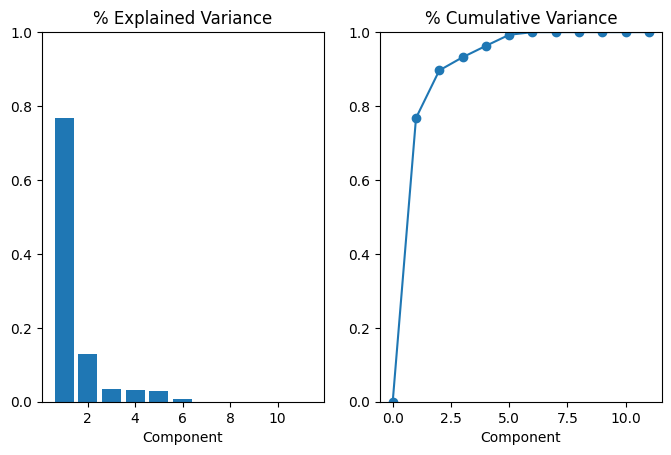

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

In [ ]:
pca_mi_scores = make_mi_scores(X_train_8_pca, y_train)
pca_mi_scores

PC1     0.474912
PC11    0.446707
PC5     0.391117
PC7     0.221936
PC2     0.215684
PC4     0.212344
PC6     0.211590
PC3     0.121224
PC9     0.095237
PC10    0.049535
PC8     0.041966
Name: MI Scores, dtype: float64

In [ ]:
X_train_8_pca_2 = pca.fit_transform(imputed_X_train_8)

# Convert to dataframe
component_names = [f"PC{i+12}" for i in range(X_train_8_pca_2.shape[1])]
X_train_8_pca_2 = pd.DataFrame(X_train_8_pca_2, columns=component_names)

X_train_8_pca_2.head()

,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51
0,-36450.759621,-25615.645320,-398.984364,1355.617833,-11012.282030,-5570.279979,5096.238901,-2206.098147,-2695.979484,841.070566,...,0.048880,0.592562,0.246617,0.512910,0.064445,0.012308,-0.417511,-0.190116,9.065389e-11,2.327927e-11
1,-30474.225639,-3732.840473,24179.800857,7043.582875,2546.191692,-11236.401561,4363.858851,6956.012504,-5126.459363,268.059416,...,0.280355,0.037414,-0.281468,0.654836,-0.238475,0.440812,0.093753,0.503879,-3.209512e-11,-7.424638e-12
2,-52540.286644,17510.242588,4976.041655,5386.683557,-6374.880790,363.074084,-724.450593,4168.587005,8293.955280,781.639542,...,0.046887,-0.190977,-0.693156,0.881415,-0.011450,0.026410,0.003024,-0.465836,7.699556e-11,-2.699682e-12
3,46132.295828,-32960.956499,1752.549169,-3128.330641,7774.546368,746.854067,-1344.627242,8253.332797,-7554.503693,83.202556,...,0.168478,-0.122551,0.131304,-0.615404,0.566403,0.529908,0.053283,-0.049705,-2.638559e-12,-1.874108e-11
4,-983.412807,-10805.732109,4968.340761,10849.133785,3723.165598,-229.042212,-18443.572463,-2031.521157,-298.580596,759.130505,...,0.031052,0.203956,0.544264,0.544615,0.106346,-0.181069,0.072451,-0.009785,5.620816e-12,-1.332236e-12


In [ ]:
X_test_8_pca_2 = pca.fit_transform(imputed_X_test_8)

# Convert to dataframe
component_names = [f"PC{i+12}" for i in range(X_test_8_pca_2.shape[1])]
X_test_8_pca_2 = pd.DataFrame(X_test_8_pca_2, columns=component_names)

X_test_8_pca_2.head()

,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51
0,-12213.411852,-29049.842664,9045.205044,-2605.412966,-8217.804934,-9773.327089,698.942381,2187.164847,1887.988908,195.077296,...,-0.086861,-0.150525,-0.090008,0.177193,-0.211598,0.000457,0.048407,0.031002,4.097937e-12,1.388457e-11
1,10607.373521,1419.293985,6932.344165,-10178.088069,1576.335660,-9036.173232,1629.106514,3927.170087,-1143.394306,-3479.118833,...,-0.589709,-0.483063,-0.110890,-0.363121,-0.020211,0.116445,0.151814,0.002635,-1.519598e-11,-1.409684e-11
2,21557.394434,-799.604544,8463.261049,7008.077277,-2107.892861,-6662.745169,1630.565686,777.177717,901.647742,81.666674,...,0.412983,0.373269,0.032178,0.054653,0.016218,0.139552,0.191811,0.030685,1.071717e-11,2.443569e-11
3,-42073.989929,-20588.809805,-9150.287812,15636.598116,7212.424278,6531.698836,-11944.788558,-8096.447887,-2466.664361,478.639242,...,-0.419018,0.622667,-0.028607,-0.133216,-0.159976,-0.625115,-0.068324,-0.153558,-3.000124e-12,7.293131e-12
4,15710.869487,-14374.072731,1440.068025,-5808.264060,-9188.606627,-7438.708836,-310.180126,-284.942792,3106.095871,124.958572,...,0.193113,0.572613,0.038968,-0.311631,-0.167665,0.071984,0.071120,0.101823,4.928234e-12,1.775404e-12


In [ ]:
loadings_2 = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=imputed_X_train_8.columns,  # and the rows are the original features
)
loadings_2

,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51
brand,-6.628393e-02,6.533693e-01,2.085621e-01,-5.068128e-01,-9.008358e-02,4.784159e-01,-1.500167e-01,-2.021111e-02,-9.187036e-02,-2.679636e-03,...,1.934555e-06,1.779470e-06,3.308657e-06,3.879168e-06,-1.070107e-06,-1.023608e-06,-8.480020e-06,3.813085e-07,-0.000000e+00,-0.000000e+00
model,-2.316904e-02,1.240808e-01,5.390446e-02,-3.992785e-02,7.851605e-02,-2.561450e-02,1.434872e-02,1.567518e-01,9.736285e-01,-4.098103e-03,...,5.465032e-06,1.396034e-06,1.088378e-06,-4.343425e-06,2.086335e-06,2.568323e-06,6.201864e-06,-9.333192e-07,5.837470e-18,2.438132e-17
year,-7.347803e-05,-1.006721e-05,-1.640083e-05,9.188512e-05,6.734122e-07,-2.787893e-05,1.010373e-04,3.298909e-05,5.262359e-05,-1.809634e-04,...,-4.912426e-03,9.487416e-03,-1.147703e-02,1.487109e-02,8.613132e-03,-1.298148e-02,-2.199016e-03,1.699054e-02,6.463000e-17,-1.119993e-15
mileage,9.797201e-01,1.737344e-01,-8.450308e-02,4.938068e-02,-2.908923e-03,-6.950568e-03,1.406593e-02,9.060575e-03,6.248977e-03,-3.154703e-03,...,-8.587739e-07,-1.734804e-07,-1.149787e-06,7.178595e-07,7.524852e-07,-5.073090e-07,1.901857e-07,7.885735e-07,-1.056110e-17,-1.801095e-17
engine,-7.377219e-02,4.518488e-01,1.395556e-01,1.252479e-01,7.296033e-01,-4.517289e-01,-2.481905e-02,-5.034883e-02,-1.241074e-01,1.714487e-02,...,-1.569762e-06,2.767760e-07,-3.651669e-06,-3.369980e-06,-2.122918e-07,-8.259182e-07,-5.190112e-06,-4.985561e-07,9.955599e-18,-2.370392e-17
engine_size,-2.739393e-06,3.054899e-05,5.783069e-06,2.366968e-05,1.080602e-06,-4.318585e-05,-2.961850e-06,2.074859e-05,3.226960e-05,3.968617e-04,...,4.451725e-04,1.005092e-03,-1.043482e-03,2.281806e-04,1.496815e-03,-1.884056e-03,-7.109442e-04,7.629241e-04,-2.952370e-17,-2.513484e-16
transmission,-8.372065e-02,3.158777e-01,1.426330e-01,8.491379e-01,-1.612627e-01,3.503051e-01,-4.719335e-02,-2.404823e-02,1.140922e-02,-1.333060e-02,...,-4.684177e-06,-3.763699e-06,-3.866752e-07,-2.644184e-06,4.826215e-06,-6.715388e-07,4.583731e-06,-1.605173e-06,-3.057951e-17,1.885203e-17
automatic_transmission,-6.892079e-07,2.448455e-06,1.262282e-06,4.409581e-06,-2.282564e-06,-4.280538e-07,1.889147e-06,4.214294e-07,2.707306e-06,-9.644345e-06,...,-6.241842e-02,1.227924e-02,8.560713e-02,-7.525665e-02,-9.724800e-01,7.302594e-02,1.007880e-01,5.452021e-02,-6.119606e-15,7.830447e-14
fuel_type,-3.196268e-03,-3.599387e-04,-6.115174e-03,-7.287956e-03,1.783759e-02,-1.092915e-02,-8.243359e-03,1.438542e-03,-6.034319e-03,-9.996772e-01,...,2.813020e-06,3.903190e-06,4.147634e-06,4.701848e-06,1.028238e-05,-4.370043e-07,3.686030e-06,-5.763220e-07,-5.678360e-19,-4.383749e-18
drivetrain,-4.560936e-02,3.170039e-01,1.832958e-01,-7.842777e-03,-6.496134e-01,-6.594328e-01,-1.753297e-02,-8.106129e-02,-3.630046e-03,-5.364583e-03,...,3.264640e-06,9.428694e-07,1.516739e-06,-2.745512e-06,2.774673e-06,2.088154e-06,1.135861e-05,3.937822e-07,2.021346e-18,8.791830e-18


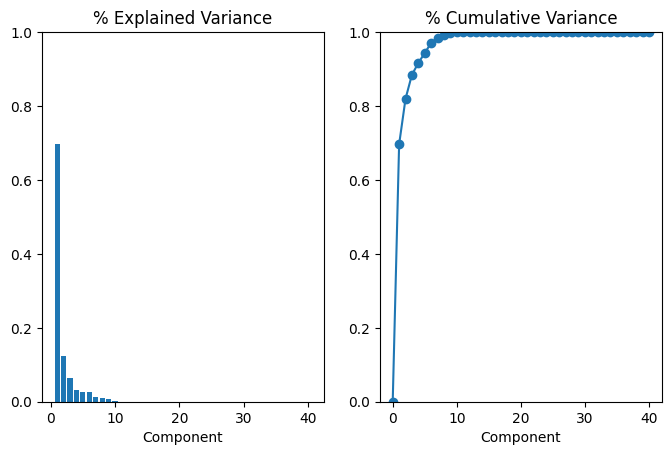

In [ ]:
plot_variance(pca);

In [ ]:
pca_mi_scores_2 = make_mi_scores(X_train_8_pca_2, y_train)
pca_mi_scores_2

PC12    0.476308
PC14    0.242417
PC16    0.197335
PC13    0.194075
PC22    0.193315
PC21    0.180750
PC46    0.135529
PC28    0.120571
PC20    0.119545
PC49    0.115497
PC18    0.109992
PC25    0.099022
PC48    0.092322
PC15    0.086993
PC19    0.085333
PC45    0.059646
PC17    0.058030
PC39    0.048683
PC47    0.043035
PC44    0.040978
PC32    0.038689
PC30    0.038291
PC23    0.037413
PC31    0.034737
PC36    0.033797
PC24    0.031273
PC26    0.029672
PC43    0.025968
PC37    0.025583
PC29    0.025444
PC27    0.025160
PC38    0.024184
PC34    0.018800
PC35    0.018411
PC33    0.017030
PC42    0.015299
PC41    0.014606
PC40    0.014194
PC51    0.008837
PC50    0.000000
Name: MI Scores, dtype: float64

As we can see, PCA has yielded some very desirable results (both from general PCA feature construction and special ones specifically created from certain attributes and new features that provide a muhc better clarity for the given dataset. We can use these features that we've analysed and the features we've created to predict now.

Note : Not all PCA features are useful and care must be taken when cosidering them to prevent overfitting the model

In [ ]:
X_train_9=imputed_X_train_8.copy()
X_train_9=X_train_9.join(X_train_8_pca)
X_train_9=X_train_9.join(X_train_8_pca_2)
print(X_train_9.columns)

X_test_9=imputed_X_test_8.copy()
X_test_9=X_test_9.join(X_test_8_pca)
X_test_9=X_test_9.join(X_test_8_pca_2)
print(X_test_9.columns)

Index(['brand', 'model', 'year', 'mileage', 'engine', 'engine_size',
       'transmission', 'automatic_transmission', 'fuel_type', 'drivetrain',
       'min_mpg', 'max_mpg', 'damaged', 'first_owner', 'personal_using',
       'turbo', 'alloy_wheels', 'adaptive_cruise_control', 'navigation_system',
       'power_liftgate', 'backup_camera', 'keyless_start', 'remote_start',
       'sunroof/moonroof', 'automatic_emergency_braking', 'stability_control',
       'leather_seats', 'memory_seat', 'third_row_seating',
       'apple_car_play/android_auto', 'bluetooth', 'usb_port', 'heated_seats',
       'interior_color', 'exterior_color', 'avg_mpg', 'Amenities',
       'mileage_per_size', 'Cluster', 'Cluster_Prob', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12',
       'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21',
       'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30',
       'PC31', 'PC32', 'PC33', 'PC34

In [ ]:
X_train_9_mi_scores=make_mi_scores(X_train_9,y_train)

In [ ]:
print(X_train_9_mi_scores.head(50))

model                          0.566501
engine                         0.529684
PC12                           0.476207
PC1                            0.474863
PC11                           0.446877
PC5                            0.391038
year                           0.361678
mileage                        0.354053
Cluster                        0.318409
engine_size                    0.283155
mileage_per_size               0.276308
brand                          0.272921
transmission                   0.252036
PC14                           0.242373
PC7                            0.222098
Amenities                      0.216765
PC2                            0.215947
PC4                            0.212262
PC6                            0.211887
exterior_color                 0.208488
PC16                           0.197240
PC13                           0.194172
PC22                           0.193238
PC21                           0.180399
drivetrain                     0.156296


##Now, from the above features, we can pick the features we want and work accordingly.

##Note 1 : PCAs generated from whole feature set must be carefully considered if to be used, as using too many of them with the initial features can lead to overfitting issues

##Note 2 : Care must be taken while target encoding to prevent target leakage, which can lead to massive overfitting issues. Build them sparesely and with care. In this exercise, features were target encoded only as a demonstration and not all target encodings were useful, nor required

##Note 3 : from the above features, of what is selected, we can continue the last bit of data processing by removing outliers and scaling, and then model can be built

#Thank You!!!

#By : Karthik Sabareesh


Github: https://github.com/KarthikSabareesh